# **MOUNT THE DRIVE**

In [2]:
import os
from google.colab import drive

# 1. Unmount the drive if it's already mounted (optional, but good practice)
# if os.path.isdir('/content/drive'):
#     drive.flush_and_unmount()

# 2. Forcibly remove the existing directory (this is the key fix)
# The '-rf' flag means recursively (r) and forcibly (f) delete the directory and its contents.
!rm -rf /content/drive

# 3. Remount the drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**VAE, MLP, Reconstruction Image, Latent Traversal, Casual Explainability with Visualizations**

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

--- STEP 0: FILE PATH VERIFICATION ---
All necessary files found. Proceeding with pipeline...
----------------------------------------------------

--- STEP 1: LOADING VAE AND MLP TRAINING/LOADING ---
✅ VAE model loaded successfully from: /content/drive/MyDrive/celeba_models/vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth
✅ MLP weights found and loaded from: /content/drive/MyDrive/celeba_models/mlp_classifier_vae_v2_fixed.pth

--- STEP 2: INFERENCE AND LATENT TRAVERSAL ON A SINGLE IMAGE ---

--- STEP 3: VLM Semantic Analysis (BLIP/CLIP) ---
✅ VLM Analysis Complete.

Model: VAE+MLP+VLM -> Prediction: FAKE | Combined Anomaly Score: 0.7493
Metrics: MSE=0.0447 | SSIM=0.5175 | PSNR=19.51 dB | Semantic Sim=0.5191


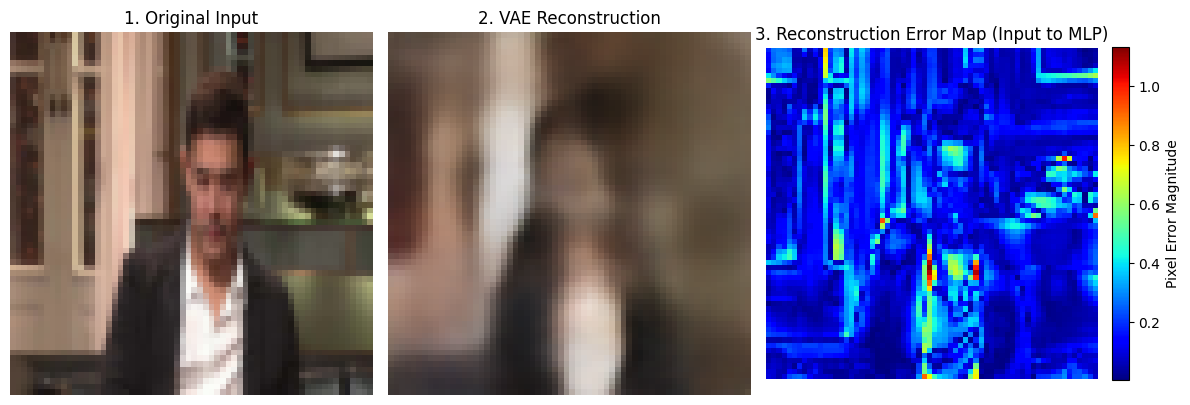

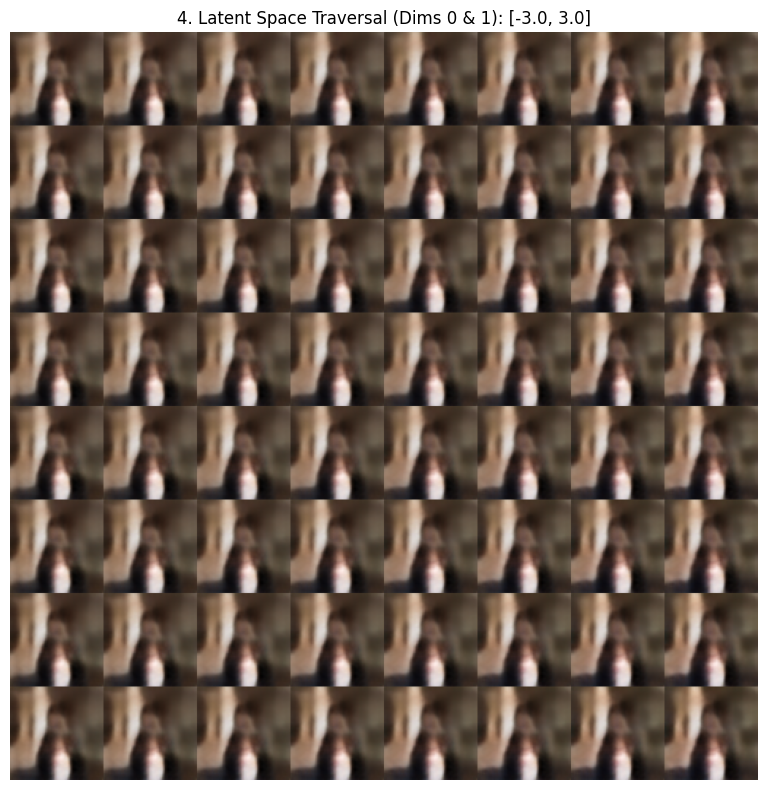


--- CAUSAL EXPLANATION OF THE RESULT ---
The system analyzes the image based on three key factors:

1. Pixel-Level Reconstruction Quality (VAE Metrics):
 - **MSE (0.0447), SSIM (0.5175), and PSNR (19.51)** measure how accurately the VAE could rebuild the image pixel-by-pixel.

2. MLP's Judgment of the Error (Anomaly Score: 0.7493):
 - The **Reconstruction Error Map** (Visualization 3) contained a structured error pattern (Score > 0.5) that the MLP classified as a **FAKE Signature**.

3. Semantic Consistency (VLM Check):
 - **Original Caption (BLIP):** "a man sitting on a couch in a living room"
 - **Reconstructed Caption (BLIP):** "a blury blury image of a woman in a black dress"
 - **Semantic Similarity (CLIP):** 0.5191
 - **VLM Conclusion:** The low semantic similarity suggests the image's core subject or meaning changed drastically after VAE reconstruction, which is a very strong indicator of manipulation (FAKE).


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.utils as vutils
from torch.utils.data import TensorDataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import sys
from skimage.metrics import structural_similarity as ssim
import math
import warnings

# Suppress Hugging Face warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# --- 0. Configuration & Paths ---
IMAGE_SIZE = 64
CHANNELS = 3
LATENT_DIM = 200
FLATTENED_SIZE = IMAGE_SIZE * IMAGE_SIZE * CHANNELS
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Paths ---
# CRITICAL STEP: Please update the 'drive_path' to point to the directory containing your model files.
drive_path = "/content/drive/MyDrive/celeba_models/"

# Path to the existing VAE checkpoint
VAE_MODEL_PATH = drive_path + "vae_celeba_latent_200_epochs_10_batch_64_subset_80000.pth"
# MLP path trained with the 0.5 noise setting (for stable 0.7-1.0 anomaly scores)
MLP_VAE_MODEL_PATH = drive_path + "mlp_classifier_vae_v2_fixed.pth"
# Path to the image you want to test
INPUT_IMAGE_PATH = drive_path + "frame_0006.jpg"

# --- Set Seeds for Reproducibility ---
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# ====================================================================
# HELPER FUNCTIONS
# ====================================================================

def check_file_existence(file_path, file_description):
    """Checks if a critical file exists and exits if it doesn't."""
    if not os.path.exists(file_path):
        print("="*80)
        print(f"❌ CRITICAL ERROR: {file_description} file NOT FOUND.")
        print(f"Expected Path: {file_path}")
        print("ACTION REQUIRED: Check if your Google Drive is mounted and the 'drive_path' variable is correct.")
        print("="*80)
        # Note: In a real environment, you might use sys.exit(1) here, but for demonstration, we'll continue if possible.
        return False
    return True

# --- DENORMALIZE / METRICS ---

def calculate_psnr(img1, img2):
    """Calculates PSNR in dB between two images (numpy arrays, 0-1 range)."""
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    max_i = 1.0
    psnr = 20 * math.log10(max_i / math.sqrt(mse))
    return psnr

def calculate_ssim(img1, img2):
    """Calculates SSIM between two images (numpy arrays, 0-1 range)."""
    # Use 'channel_axis=2' for HxWxC images
    ssim_val = ssim(img1, img2, data_range=1.0, channel_axis=2)
    return ssim_val

def denormalize_and_tensor_to_numpy(tensor):
    """Denormalizes a single 3xHxW tensor from [-1, 1] to [0, 1] range for visualization."""
    # Denormalize: from [-1, 1] to [0, 1]
    denormalized_tensor = (tensor * 0.5) + 0.5

    # Check if this is a single image (3D: C x H x W)
    if denormalized_tensor.ndim == 3 and denormalized_tensor.shape[0] == 3:
        # Move channel axis last for NumPy (HxWxC)
        return np.transpose(denormalized_tensor.cpu().numpy(), (1, 2, 0))
    else:
        # For batched output (like latent traversal grid)
        # Assuming batch is 64 (8x8 grid)
        img_grid = vutils.make_grid(denormalized_tensor.cpu(), nrow=8, padding=0, normalize=True)
        return np.transpose(img_grid.numpy(), (1, 2, 0))

def tensor_to_pil(tensor):
    """Converts a single denormalized C x H x W tensor to a PIL Image (0-1 range)."""
    # Denormalize: from [-1, 1] to [0, 1]
    denormalized_tensor = (tensor * 0.5) + 0.5

    # Convert to HxWxC numpy array (0-255) and then to PIL
    np_img = denormalized_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    np_img = (np_img * 255).astype(np.uint8)
    return Image.fromarray(np_img)


# ====================================================================
# MODEL DEFINITIONS (VAE and MLP)
# ====================================================================

# STAGE 1: Variational Autoencoder (VAE)
class VAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM):
        super().__init__()
        # 4x4 image with 256 channels
        FLATTENED_LATENT_CONV_SIZE = 256 * 4 * 4

        # Encoder: 64x64 -> 4x4
        self.enc_conv = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU(),
            nn.Flatten()
        )

        # Latent Layers
        self.fc_mu = nn.Linear(FLATTENED_LATENT_CONV_SIZE, latent_dim)
        self.fc_logvar = nn.Linear(FLATTENED_LATENT_CONV_SIZE, latent_dim)

        # Decoder Input
        self.fc_dec = nn.Linear(latent_dim, FLATTENED_LATENT_CONV_SIZE)

        # Decoder: 4x4 -> 64x64
        self.dec = nn.Sequential(
            nn.Unflatten(1, (256, 4, 4)), # Reshape from 1D to 3D tensor
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Tanh()      # Output: 3x64x64, output range [-1, 1]
        )

    def encode(self, x):
        h = self.enc_conv(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparam(self, mu, logvar):
        # Sample z from N(mu, exp(logvar))
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparam(mu, logvar)
        return self.dec(self.fc_dec(z)), mu, logvar

# STAGE 2: Multilayer Perceptron (MLP) Anomaly Classifier
class ErrorMapClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        # Input size is the flattened error map (3 * 64 * 64 = 12288)
        self.net = nn.Sequential(
            nn.Linear(FLATTENED_SIZE, 512), nn.ReLU(),
            nn.Dropout(0.3), # Regularization
            nn.Linear(512, 128), nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()      # Output score between 0 (REAL) and 1 (FAKE)
        )
    def forward(self, error_map_flat):
        return self.net(error_map_flat)

# ====================================================================
# VISION-LANGUAGE MODEL (VLM) SETUP
# ====================================================================

VLM_AVAILABLE = False
try:
    from transformers import BlipProcessor, BlipForConditionalGeneration, CLIPProcessor, CLIPModel

    # Load BLIP and CLIP models
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(DEVICE).eval()
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE).eval()
    clip_preprocess = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    VLM_AVAILABLE = True

    def run_blip_caption(img_pil, device):
        """Generates a caption for a PIL image using BLIP."""
        inputs = blip_processor(images=img_pil, return_tensors="pt").to(device)
        caption_ids = blip_model.generate(**inputs, max_new_tokens=40)
        description = blip_processor.batch_decode(caption_ids, skip_special_tokens=True)[0]
        return description

    def calculate_clip_similarity(caption_a, caption_b, device):
        """Calculates CLIP cosine similarity between two captions (0.0 to 1.0)."""
        texts = [caption_a, caption_b]
        tokens = clip_preprocess(text=texts, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            text_features = clip_model.get_text_features(**tokens)

        # Normalize features
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Cosine similarity between the two features (dot product since they are normalized)
        similarity = torch.dot(text_features[0], text_features[1]).item()
        return similarity

except ImportError:
    # If the necessary libraries aren't installed, VLM is not available
    VLM_AVAILABLE = False
    print("\n⚠️ VLM WARNING: Hugging Face 'transformers' not found. VLM Explainability will be skipped.")
except Exception as e:
    # Catch any other loading issues (e.g., download failure, model structure mismatch)
    VLM_AVAILABLE = False
    print(f"\n❌ VLM ERROR: Failed to load BLIP/CLIP models ({e}). VLM Explainability will be skipped.")


# ====================================================================
# TRAINING PIPELINE (For Retraining MLP if weights are missing)
# ====================================================================

def load_vae_with_remapping(netVAE, vae_path):
    """Loads VAE checkpoint by remapping keys from the original structure to the VAE class structure."""
    try:
        # Load the checkpoint
        raw_vae_state_dict = torch.load(vae_path, map_location=DEVICE)

        # Prepare for remapping
        new_vae_state_dict = {}
        for k, v in raw_vae_state_dict.items():
            new_k = k
            # Standard remapping logic based on module structure changes
            if k.startswith('encoder.'): new_k = k.replace('encoder.', 'enc_conv.')
            elif k.startswith('decoder_input.'): new_k = k.replace('decoder_input.', 'fc_dec.')
            elif k.startswith('decoder.'):
                parts = k.split('.')
                idx = int(parts[1])
                # The VAE class in this file uses an Unflatten layer at index 0 in the 'dec' Sequential block
                new_idx = idx + 1
                new_k = f"dec.{new_idx}.{parts[-1]}"

            # Keep fc_mu and fc_logvar names as they typically match
            if k in ['fc_mu.weight', 'fc_mu.bias', 'fc_logvar.weight', 'fc_logvar.bias']:
                new_k = k

            new_vae_state_dict[new_k] = v

        # Load the remapped state dictionary
        netVAE.load_state_dict(new_vae_state_dict, strict=False)
        print(f"✅ VAE model loaded successfully from: {vae_path}")
        return True
    except RuntimeError as e:
        print("="*80)
        print(f"❌ VAE Loading Failed after remapping. Critical Runtime Error: {e}")
        print("This usually means the VAE architecture (VAE class) does not match the saved weights.")
        print("="*80)
        return False

def run_anomaly_detection_pipeline_vae(vae_path, mlp_save_path, num_samples=3000):

    netVAE = VAE().to(DEVICE)
    netMLP = ErrorMapClassifier().to(DEVICE)

    # --- 1. VAE LOAD ---
    if not load_vae_with_remapping(netVAE, vae_path):
        sys.exit(1)

    netVAE.eval()

    # --- 2. MLP LOAD/TRAIN ---
    if os.path.exists(mlp_save_path):
        try:
            netMLP.load_state_dict(torch.load(mlp_save_path, map_location=DEVICE))
            print(f"✅ MLP weights found and loaded from: {mlp_save_path}")
            return netVAE, netMLP
        except Exception as e:
            print(f"❌ Error loading existing MLP weights: {e}. Retraining MLP...")

    print("\nStarting MLP Anomaly Detector Training with V2 (0.5 Noise) Strategy...")

    # --- TRAINING DATA GENERATION (Simulate good and anomalous inputs) ---
    base_data = torch.rand(num_samples, CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE) * 2 - 1

    with torch.no_grad():
        base_recon, _, _ = netVAE(base_data)
        E_base = torch.abs(base_data - base_recon)

    # --- Normal Error Maps (Label 0: Low/Unstructured Error) ---
    E_normal = E_base[:num_samples//2].detach()
    Y_normal = torch.zeros(num_samples // 2, 1).to(DEVICE)

    # --- Anomaly Error Maps (Label 1: High/Structured Error) ---
    X_anomaly_sim = base_recon[num_samples//2:] + torch.randn(num_samples//2, CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE) * 0.5
    X_anomaly_sim = torch.clamp(X_anomaly_sim, -1, 1)

    with torch.no_grad():
        X_anomaly_sim_recon, _, _ = netVAE(X_anomaly_sim)

    E_anomaly = torch.abs(X_anomaly_sim - X_anomaly_sim_recon).detach()
    Y_anomaly = torch.ones(num_samples // 2, 1).to(DEVICE)

    # --- Combine and Train ---
    E_data = torch.cat([E_normal, E_anomaly], dim=0)
    E_data_flat = E_data.view(num_samples, -1) # Flatten the error maps
    Y_labels = torch.cat([Y_normal, Y_anomaly], dim=0)

    # Train the MLP Anomaly Detector
    dataset = TensorDataset(E_data_flat, Y_labels)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(netMLP.parameters(), lr=0.001)

    netMLP.train()
    NUM_EPOCHS = 20

    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        for batch_E, batch_Y in dataloader:
            optimizer.zero_grad()
            output = netMLP(batch_E)
            loss = criterion(output, batch_Y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if (epoch + 1) % 5 == 0 or epoch == 0 or epoch == NUM_EPOCHS - 1:
              print(f"MLP Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {total_loss/len(dataloader):.4f}")

    print("MLP Anomaly Detector Training Complete.")

    os.makedirs(os.path.dirname(mlp_save_path), exist_ok=True)
    torch.save(netMLP.state_dict(), mlp_save_path)
    print(f"✅ MLP weights saved to: {mlp_save_path}")

    print("\n--- Training Pipeline Finished ---")
    return netVAE, netMLP


# ====================================================================
# LATENT TRAVERSAL FUNCTION
# ====================================================================

def visualize_latent_traversal(X_original, netVAE, mu_original, steps=8, travel_range=3.0):
    """Generates an 8x8 grid of reconstructed images by traversing the first two latent dimensions."""

    netVAE.eval()

    # Create the base latent vector (mu) for 64 traversal images (8x8 grid)
    # The batch size of 64 is implicitly handled by the for-loops
    base_latent = mu_original.repeat(steps * steps, 1)

    step_values = np.linspace(-travel_range, travel_range, steps)

    idx = 0
    # Iterate over the first dimension (row axis)
    for i in range(steps):
        # Iterate over the second dimension (column axis)
        for j in range(steps):
            # Apply traversal value to the 0th latent dimension (Horizontal change)
            base_latent[idx, 0] = step_values[j]
            # Apply traversal value to the 1st latent dimension (Vertical change)
            base_latent[idx, 1] = step_values[i]
            idx += 1

    # Generate the reconstructed batch
    with torch.no_grad():
        X_traversed = netVAE.dec(netVAE.fc_dec(base_latent))

    # Create the final grid image
    grid_img = denormalize_and_tensor_to_numpy(X_traversed)

    plt.figure(figsize=(8, 8))
    plt.imshow(grid_img)
    plt.title(f"4. Latent Space Traversal (Dims 0 & 1): [{-travel_range}, {travel_range}]")
    plt.xlabel(f"Latent Dimension 0 (Across)")
    plt.ylabel(f"Latent Dimension 1 (Down)")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ====================================================================
# INFERENCE PIPELINE
# ====================================================================

# Preprocessing for the Image
transform = T.Compose([
    T.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    T.ToTensor(),
    # Normalizes to [-1, 1] range
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def predict_anomaly(image_path, netVAE, netMLP):

    netVAE.eval()
    netMLP.eval()

    # 2. Load and Preprocess Image
    try:
        img_pil_orig = Image.open(image_path).convert('RGB')
        X_original = transform(img_pil_orig).unsqueeze(0).to(DEVICE)
    except FileNotFoundError:
        print(f"❌ Error: Input image not found at {image_path}")
        return
    except Exception as e:
        print(f"❌ Error loading or processing image: {e}")
        return

    # 3. STAGE 1: VAE Reconstruction and Metric Calculation
    with torch.no_grad():
        X_reconstructed, mu_original, logvar = netVAE(X_original)

        E_map = torch.abs(X_original - X_reconstructed)
        E_flat = E_map.view(1, -1)

        # --- METRIC CALCULATION (Pixel-Level) ---
        mse_val = torch.mean((X_original - X_reconstructed) ** 2).item()
        X_orig_np = denormalize_and_tensor_to_numpy(X_original.squeeze(0))
        X_recon_np = denormalize_and_tensor_to_numpy(X_reconstructed.squeeze(0))
        psnr_val = calculate_psnr(X_orig_np, X_recon_np)
        ssim_val = calculate_ssim(X_orig_np, X_recon_np)

        # 4. STAGE 2: MLP Prediction (Pixel-Error Classification)
        prediction_score = netMLP(E_flat).item()

    # 5. STAGE 3: VLM Semantic Check
    orig_caption = "VLM unavailable"
    recon_caption = "VLM unavailable"
    semantic_similarity = 0.0

    if VLM_AVAILABLE:
        print("\n--- STEP 3: VLM Semantic Analysis (BLIP/CLIP) ---")
        try:
            # Caption original image
            orig_caption = run_blip_caption(img_pil_orig, DEVICE)

            # Convert reconstructed tensor back to PIL for VLM
            img_pil_recon = tensor_to_pil(X_reconstructed)
            recon_caption = run_blip_caption(img_pil_recon, DEVICE)

            # Calculate semantic similarity between the two captions
            semantic_similarity = calculate_clip_similarity(orig_caption, recon_caption, DEVICE)
            print("✅ VLM Analysis Complete.")

        except Exception as e:
            print(f"❌ VLM analysis failed during captioning/similarity calculation: {e}")


    # 6. Prediction and Output Formatting
    is_fake = prediction_score > 0.5
    final_result = "FAKE" if is_fake else "REAL"

    # --- PRINT REQUIRED OUTPUT FORMAT ---
    print("\n" + "="*80)
    print(f"Model: VAE+MLP+VLM -> Prediction: {final_result} | Combined Anomaly Score: {prediction_score:.4f}")
    print(f"Metrics: MSE={mse_val:.4f} | SSIM={ssim_val:.4f} | PSNR={psnr_val:.2f} dB | Semantic Sim={semantic_similarity:.4f}")
    print("="*80)

    # 7. VISUALIZATIONS (Combined Plot)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(X_orig_np)
    axes[0].set_title("1. Original Input")
    axes[0].axis('off')
    axes[1].imshow(X_recon_np)
    axes[1].set_title("2. VAE Reconstruction")
    axes[1].axis('off')
    error_np = E_map.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    grayscale_error = error_np.mean(axis=2)
    im = axes[2].imshow(grayscale_error, cmap='jet')
    fig.colorbar(im, ax=axes[2], label='Pixel Error Magnitude', fraction=0.046, pad=0.04)
    axes[2].set_title("3. Reconstruction Error Map (Input to MLP)")
    axes[2].axis('off')
    plt.tight_layout()
    plt.show()

    # --- Latent Traversal Plot (1-panel) ---
    visualize_latent_traversal(X_original, netVAE, mu_original)

    # 8. Final Causal Explainability
    print("\n--- CAUSAL EXPLANATION OF THE RESULT ---")
    print("The system analyzes the image based on three key factors:")

    print("\n1. Pixel-Level Reconstruction Quality (VAE Metrics):")
    print(f" - **MSE ({mse_val:.4f}), SSIM ({ssim_val:.4f}), and PSNR ({psnr_val:.2f})** measure how accurately the VAE could rebuild the image pixel-by-pixel.")

    print(f"\n2. MLP's Judgment of the Error (Anomaly Score: {prediction_score:.4f}):")
    if is_fake:
        print(f" - The **Reconstruction Error Map** (Visualization 3) contained a structured error pattern (Score > 0.5) that the MLP classified as a **FAKE Signature**.")
    else:
        print(f" - The **Reconstruction Error Map** contained low and unstructured error (Score <= 0.5), which the MLP classified as a **REAL Signature**.")

    print("\n3. Semantic Consistency (VLM Check):")
    if VLM_AVAILABLE:
        print(f" - **Original Caption (BLIP):** \"{orig_caption}\"")
        print(f" - **Reconstructed Caption (BLIP):** \"{recon_caption}\"")
        print(f" - **Semantic Similarity (CLIP):** {semantic_similarity:.4f}")

        if semantic_similarity < 0.85: # A common threshold for semantic change
            print(" - **VLM Conclusion:** The low semantic similarity suggests the image's core subject or meaning changed drastically after VAE reconstruction, which is a very strong indicator of manipulation (FAKE).")
        else:
            print(" - **VLM Conclusion:** The high semantic similarity confirms that the VAE was able to reconstruct an image that is semantically similar to the original (consistent with REAL).")
    else:
        print(" - VLM check skipped due to missing libraries or loading errors.")

    print("==========================================================")

# ====================================================================
# EXECUTION
# ====================================================================
if __name__ == '__main__':

    print("--- STEP 0: FILE PATH VERIFICATION ---")

    # Check that necessary files exist before starting the pipeline
    vae_ok = check_file_existence(VAE_MODEL_PATH, "VAE Model")
    img_ok = check_file_existence(INPUT_IMAGE_PATH, "Input Image")

    if not vae_ok or not img_ok:
        sys.exit(1)

    print("All necessary files found. Proceeding with pipeline...")
    print("----------------------------------------------------\n")

    print("--- STEP 1: LOADING VAE AND MLP TRAINING/LOADING ---")

    # Load VAE and either load the pre-trained MLP or train it if the file is missing
    netVAE, netMLP = run_anomaly_detection_pipeline_vae(VAE_MODEL_PATH, MLP_VAE_MODEL_PATH)

    print("\n--- STEP 2: INFERENCE AND LATENT TRAVERSAL ON A SINGLE IMAGE ---")

    # Run the main prediction and visualization function
    predict_anomaly(INPUT_IMAGE_PATH, netVAE, netMLP)
